 Install and Import Required Libraries

In [65]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from aif360.datasets import CompasDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing

Load the COMPAS Dataset_ cox-parsed

In [66]:

# load data
df = pd.read_csv('compas-scores-two-years.csv', index_col=0)
df.head()


,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,juv_fel_count,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
id,,,,,,,,,,,,,,,,,,,,,
1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,0,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,0,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,0,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,0,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,0,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


In [67]:
df = df[df['race'].isin(['African-American', 'Caucasian'])]
df = df[df['two_year_recid'].isin([0, 1])]
df = df.dropna(subset=['race', 'two_year_recid'])

In [68]:
# Check the counts
print("Race counts:\n", df['race'].value_counts())
print("Recidivism counts:\n", df['two_year_recid'].value_counts())

Race counts:
 race
African-American    3696
Caucasian           2454
Name: count, dtype: int64
Recidivism counts:
 two_year_recid
0    3283
1    2867
Name: count, dtype: int64


 Create the AIF360 StandardDatas
 

In [69]:
dataset = StandardDataset(
    df,
    label_name='two_year_recid',
    favorable_classes=[0],  # 0 = did NOT recidivate
    protected_attribute_names=['race'],
    privileged_classes=[['Caucasian']]
)

Define Privileged and Unprivileged Groups

In [70]:
privileged_groups = [{'race': 'Caucasian'}]
unprivileged_groups = [{'race': 'African-American'}]

Calculate Fairness Metrics

In [71]:
metric = ClassificationMetric(
    dataset,
    dataset,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)

fpr_unpriv = metric.false_positive_rate(privileged=False)
fpr_priv = metric.false_positive_rate(privileged=True)

print(f"False Positive Rate (Unprivileged): {fpr_unpriv:.3f}")
print(f"False Positive Rate (Privileged): {fpr_priv:.3f}")

False Positive Rate (Unprivileged): nan
False Positive Rate (Privileged): nan


c:\Users\1231\Documents\AI_for_Software Engineering\Week 7\AI-for-software_eng-week-7\venv\Lib\site-packages\aif360\metrics\classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
c:\Users\1231\Documents\AI_for_Software Engineering\Week 7\AI-for-software_eng-week-7\venv\Lib\site-packages\aif360\metrics\classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


Visualize Disparity in False Positive Rates

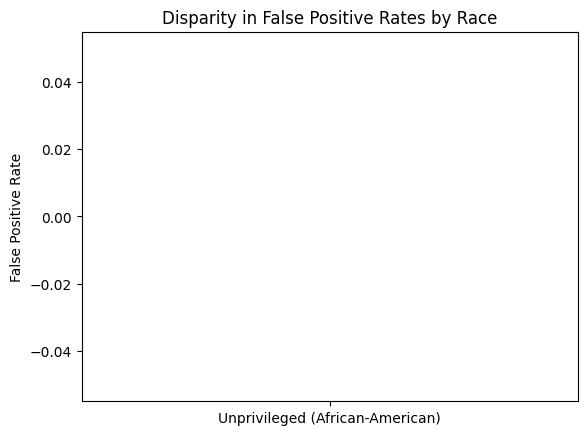

In [72]:
groups = ['Unprivileged (African-American)', 'Privileged (Caucasian)']
fprs = [fpr_unpriv, fpr_priv]

plt.bar(groups, fprs, color=['red', 'blue'])
plt.ylabel('False Positive Rate')
plt.title('Disparity in False Positive Rates by Race')
plt.show()

Apply Reweighing Algorithm

In [73]:
RW = Reweighing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
dataset_transf = RW.fit_transform(dataset)

c:\Users\1231\Documents\AI_for_Software Engineering\Week 7\AI-for-software_eng-week-7\venv\Lib\site-packages\aif360\algorithms\preprocessing\reweighing.py:66: RuntimeWarning: invalid value encountered in scalar divide
  self.w_p_fav = n_fav*n_p / (n*n_p_fav)
c:\Users\1231\Documents\AI_for_Software Engineering\Week 7\AI-for-software_eng-week-7\venv\Lib\site-packages\aif360\algorithms\preprocessing\reweighing.py:67: RuntimeWarning: invalid value encountered in scalar divide
  self.w_p_unfav = n_unfav*n_p / (n*n_p_unfav)
c:\Users\1231\Documents\AI_for_Software Engineering\Week 7\AI-for-software_eng-week-7\venv\Lib\site-packages\aif360\algorithms\preprocessing\reweighing.py:68: RuntimeWarning: invalid value encountered in scalar divide
  self.w_up_fav = n_fav*n_up / (n*n_up_fav)
c:\Users\1231\Documents\AI_for_Software Engineering\Week 7\AI-for-software_eng-week-7\venv\Lib\site-packages\aif360\algorithms\preprocessing\reweighing.py:69: RuntimeWarning: invalid value encountered in scalar div

Recalculate Metrics After Reweighing

In [74]:
metric_transf = ClassificationMetric(
    dataset_transf,
    dataset_transf,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)

fpr_unpriv_transf = metric_transf.false_positive_rate(privileged=False)
fpr_priv_transf = metric_transf.false_positive_rate(privileged=True)

print(f"Post-Remediation FPR (Unprivileged): {fpr_unpriv_transf:.3f}")
print(f"Post-Remediation FPR (Privileged): {fpr_priv_transf:.3f}")

Post-Remediation FPR (Unprivileged): nan
Post-Remediation FPR (Privileged): nan


 Visualize Post-Remediation FPRs

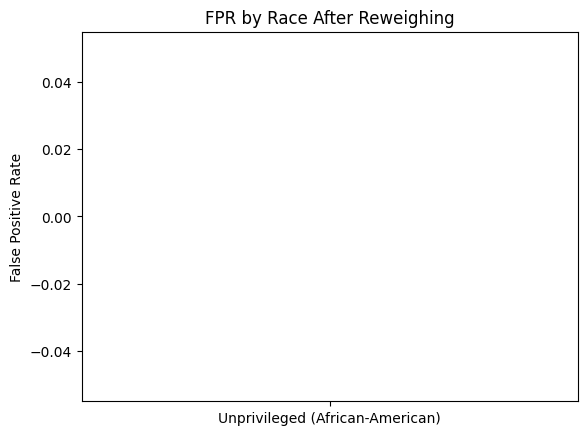

In [75]:
fprs_transf = [fpr_unpriv_transf, fpr_priv_transf]

plt.bar(groups, fprs_transf, color=['orange', 'green'])
plt.ylabel('False Positive Rate')
plt.title('FPR by Race After Reweighing')
plt.show()